# Descriptives

## Summer School JGU Mainz — Advanced Methods in Behavioral Economics, 2021

### Carina I. Hausladen

In [11]:
from datetime import datetime
print(datetime.now().strftime("%Y-%m-%d"))

2021-09-28


# Data
In this notebook, we investigate decision and chat data from a [laboratory experiment](https://www.socialscienceregistry.org/trials/5049).

# Details on the laboratory experiment
* The participant works as an employee for a fictitious company. 
* Together with one additional team member, she completed a project for which both team members worked the same surplus hours. 
* Both team members could coordinate in a chat about the number of surplus hours they wished to state: The higher the stated amount, the higher was the salary that the fictitious company would pay. 
* If the team members' reports diverged, the couple was controlled. Couples that reported the same amount of hours were randomly controlled with a probability of $30%$. 
* If the participant got controlled and reported more than ten surplus hours, she paid a fine.

In [12]:
import warnings
warnings.simplefilter("ignore")

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from nltk import word_tokenize

from utils.setup import prepare_docs

In [13]:
df_chat_hours = pd.read_csv('data/chat_hours_simulated.csv')
df_prep_new, all_docs_new = prepare_docs(df_chat_hours, y="honest10", X="Chat_subject", dv="player.hours_stated")

In [14]:
print(len(df_chat_hours))
df_chat_hours[[
 'player.hours_stated',
 'equal',
 'Chat_subject',
 'Chat_group_all',
 'Chat_sel',
 'honest10',
 'honest30',
 'honestmean',
 'honest3label']].head()

351


,player.hours_stated,equal,Chat_subject,Chat_group_all,Chat_sel,honest10,honest30,honestmean,honest3label
0,15.0,True,"Hallo, wie wäre es denn, wenn wir bei der Wahr...","Wir haben 15 Überstunden Hallo, wie wäre es d...","Wir haben 15 Überstunden Hallo, wie wäre es d...",0,1,1,2
1,15.0,True,Wir haben 15 Überstunden finde ich völlig in ...,"Wir haben 15 Überstunden Hallo, wie wäre es d...","Wir haben 15 Überstunden Hallo, wie wäre es d...",0,1,1,2
2,17.0,True,wollen wir die richtige Anzahl angeben mir ega...,wollen wir die richtige Anzahl angeben willst ...,wollen wir die richtige Anzahl angeben willst ...,0,1,1,2
3,10.0,True,willst du die wahrheit sagen? smiley aber es w...,wollen wir die richtige Anzahl angeben willst ...,wollen wir die richtige Anzahl angeben willst ...,1,1,1,1
4,50.0,True,Reichen dir die 15 ? ok mir ists eigentlich eg...,Reichen dir die 15 ? Hallo ja und diR ? ok mir...,Reichen dir die 15 ? Hallo ja und diR ? ok mir...,0,0,0,2


# Describe y
In most behavioral experiments a decision has to be made, either binary or within a continuum.

## y, a continuous variable
- Participants in our experiment report surplus hours. 
- The more surplus hours worked, the more they will earn.
- The full dishonesty benchmark is denoted by $60$, the full honest benchmark by $10$.

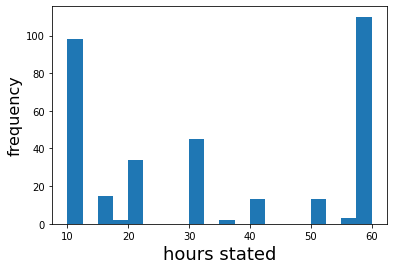

In [15]:
df = pd.read_csv('data/chat_hours_simulated.csv')
df[['player.hours_stated']].hist(bins=20, grid=False)
plt.title("")
plt.xlabel('hours stated', fontsize=18)
plt.ylabel('frequency', fontsize=16)
plt.show()

## Feature engineering: binarize y

* In many cases, a numeric decision can be mapped to a broader, binary concept. 
* In the case of group communication in the context of compliance decisions, the question might for example be: Is communication in the case of full cooperation structurally different than in the case of partial cooperation? 
* Categories depend on the applied thresholds.
* Setting this threshold can be either based on theory (or the specific research question) or derived by data inspection (e.g., if the goal of the analysis is only to increase prediction performance). 
* If a threshold is chosen not based on theoretical arguments, but based on classification performance, the chosen threshold is of course not "better" than others, it is just an "easier" threshold for the classifier to work with. 

🤓: You could introduce two thresholds, dividing the continuum into three parts. Which thresholds would make sense? Implement your thresholds for `df[['player.hours_stated']]`.

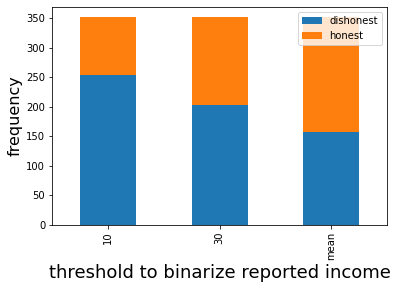

In [16]:
plot_df = pd.DataFrame()
plot_df["10"] = df_prep_new["honest10"].value_counts()
plot_df["30"] = df_prep_new["honest30"].value_counts()
plot_df["mean"] = df_prep_new["honestmean"].value_counts()
plot_df = plot_df.rename(index={1: "honest",
                                2: "undefined",
                                0: "dishonest"})

plot_df.T.plot(kind="bar", stacked=True)
plt.legend(loc='best')  # , bbox_to_anchor=(0.5, 0., 0.5, 0.5))
plt.xlabel('threshold to binarize reported income', fontsize=18)
plt.ylabel('frequency', fontsize=16)
plt.show()

In [17]:
print(df_prep_new["honest10"].value_counts()) 
print(df_prep_new["honest30"].value_counts()) 
print(df_prep_new["honestmean"].value_counts())

0    253
1     98
Name: honest10, dtype: int64
0    202
1    149
Name: honest30, dtype: int64
1    194
0    157
Name: honestmean, dtype: int64


## Imbalanced Datasets
- Learning and prediction of machine learning algorithms can be affected by an imbalanced data set.
- One approach to address the problem of class imbalance is to randomly resample the training dataset. 
- Two main approaches 
    - delete examples from the majority class (undersampling)
    - duplicate examples from the minority class (oversampling)
- We deploy naive random over-sampling, via the [RandomOverSampler class](https://imbalanced-learn.org/stable/references/generated/imblearn.over_sampling.RandomOverSampler.html).

🤓: There exist more advanced oversampling methods (e.g. ADASYN, SMOTE). Check [imbalanced-learn](https://imbalanced-learn.org/stable/auto_examples/over-sampling/plot_comparison_over_sampling.html) if you are interested.

We explore the impact of training a logistic regression classifier with different levels of class balancing.

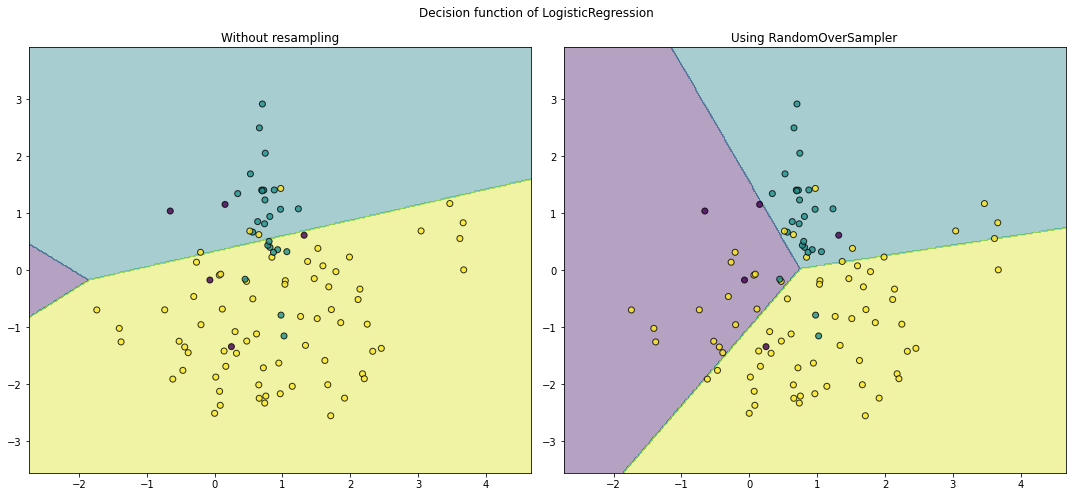

In [18]:
from utils.visualization import plot_decision_function_comparison
plot_decision_function_comparison()

# Chats (X)

* In several experimental games, a group chat precedes the actual (numeric) decision. 
* The subsequent decision is oftentimes taken individually, e.g., when each group member decides about the amount of income to state. 
* Consequently, group chats or individual's chat messages might be used to predict the numerical decision.
* A participant's decision might depend upon whether the group reached an agreement or not. Non-agreement might lead to an individual up weighing his/her statements, whereas in the case of agreement, the whole group chat influences the decision `chat_sel`.
* Spelling mistakes are common in user-generated content. Thus, the variations proposed above can be implemented on text with and without spellchecking.

In [19]:
df_chat_hours[[
 'Chat_subject',
 'Chat_group_all',
 'Chat_sel']]

,Chat_subject,Chat_group_all,Chat_sel
0,"Hallo, wie wäre es denn, wenn wir bei der Wahr...","Wir haben 15 Überstunden Hallo, wie wäre es d...","Wir haben 15 Überstunden Hallo, wie wäre es d..."
1,Wir haben 15 Überstunden finde ich völlig in ...,"Wir haben 15 Überstunden Hallo, wie wäre es d...","Wir haben 15 Überstunden Hallo, wie wäre es d..."
2,wollen wir die richtige Anzahl angeben mir ega...,wollen wir die richtige Anzahl angeben willst ...,wollen wir die richtige Anzahl angeben willst ...
3,willst du die wahrheit sagen? smiley aber es w...,wollen wir die richtige Anzahl angeben willst ...,wollen wir die richtige Anzahl angeben willst ...
4,Reichen dir die 15 ? ok mir ists eigentlich eg...,Reichen dir die 15 ? Hallo ja und diR ? ok mir...,Reichen dir die 15 ? Hallo ja und diR ? ok mir...
...,...,...,...
346,"Hallo, möchtest du 10 Punkte angeben und siche...","10 Überstunden Hallo, möchtest du 10 Punkte an...","10 Überstunden Hallo, möchtest du 10 Punkte an..."
347,kein_chat,kein_chat,kein_chat
348,kein_chat,kein_chat,kein_chat
349,Hallo Welche Überstundenanzahl werden wir ange...,Hallo Ebenfalls hallo Welche Überstundenanzahl...,Hallo Ebenfalls hallo Welche Überstundenanzahl...


## Distribution of the number of words
Chats after which participants decide to report honestly have slightly fewer words as opposed to dishonest charts.

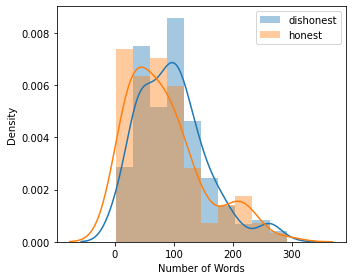

In [20]:
all_docs = all_docs_new
df = df_chat_hours
df = df.rename(columns={"honest10": "honest1000"})
s = df.Chat_group_all.str.len().sort_values().index

dishonest = [len(word_tokenize(Chat_group_all)) for Chat_group_all in
             df[df.honest1000.values == 0].Chat_group_all.values]
honest = [len(word_tokenize(Chat_group_all)) for Chat_group_all in df[df.honest1000.values != 0].Chat_group_all.values]

plt.figure(figsize=(5,4))
sns.distplot(dishonest, bins=10, label='dishonest')
sns.distplot(honest, bins=10, label='honest')
plt.legend()
plt.xlabel('Number of Words')
plt.tight_layout()
plt.show()

## Mean word length 
Mean word length is similar across honest and dishonest chats.

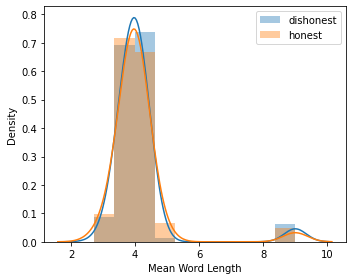

In [21]:
def mean_word_length(x):
    word_lengths = np.array([])
    for word in word_tokenize(x):
        word_lengths = np.append(word_lengths, len(word))
    return word_lengths.mean()

dishonest_len = df[df.honest1000.values == 0].Chat_group_all.apply(mean_word_length)
honest_len = df[df.honest1000.values != 0].Chat_group_all.apply(mean_word_length)

plt.figure(figsize=(5,4))
sns.distplot(dishonest_len, bins=10, label='dishonest')
sns.distplot(honest_len, bins=10, label='honest')
plt.xlabel('Mean Word Length')
plt.legend()
plt.tight_layout()
plt.show()

## Stopwords
The number of stopwords is similar across honest and dishonest chats.

In [22]:
from nltk.corpus import stopwords
# nltk.download('stopwords') #uncomment if you have not yet downloaded
stop_words = set(stopwords.words('german'))

def stop_words_ratio(x):
    num_total_words = 0
    num_stop_words = 0
    for word in word_tokenize(x):
        if word in stop_words:
            num_stop_words += 1
        num_total_words += 1
    return num_stop_words / num_total_words

dishonest Mean: 0.331
honest Mean: 0.348


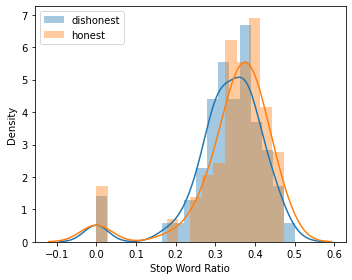

In [24]:
dishonest = df[df.honest1000.values == 0].Chat_group_all.apply(stop_words_ratio)
honest = df[df.honest1000.values != 0].Chat_group_all.apply(stop_words_ratio)

plt.figure(figsize=(5,4))
sns.distplot(dishonest, norm_hist=True, label='dishonest')
sns.distplot(honest, label='honest')

print('dishonest Mean: {:.3f}'.format(dishonest.values.mean()))
print('honest Mean: {:.3f}'.format(honest.values.mean()))
plt.xlabel('Stop Word Ratio')
plt.legend()
plt.tight_layout()
plt.show()

# It's your turn! 🧑‍💻 ~10'